In [123]:
%matplotlib inline
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import gdal
from mpl_toolkits.basemap import Basemap
import math

In [124]:
data_dir = 'test_data'
file_list = glob(os.path.join(data_dir, '*.tif'))
print(file_list)

['test_data/livneh_year_Tmax_clip_15Oct2014.1961.tif', 'test_data/livneh_year_Tmax_clip_15Oct2014.1963.tif', 'test_data/livneh_year_Tmax_clip_15Oct2014.1962.tif', 'test_data/output.tif']


In [125]:
def read_file(file):
    ds = gdal.Open(file)
    band = ds.GetRasterBand(1)
    # Get nodata value from the GDAL band object
    nodata = band.GetNoDataValue()
    # Creates a numpy array that contains the original nodata values. 
    data = band.ReadAsArray()
    # Any calculations will be wrong if nodata values are not taken care of
    # Create a masked array for making calculations without nodata values
    rasterArray = np.ma.masked_equal(data, nodata)
    band = None
    ds = None
    return rasterArray

In [126]:
# Read all data as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]

In [127]:
# Perform averaging
array_out = np.ma.array(tuple(array_list)).mean(axis=0)
print(array_out.min(), array_out.max(), type(array_out))

0.0 34.7185096741 <class 'numpy.ma.core.MaskedArray'>


In [130]:
# Get metadata from one of the input files
ds = gdal.Open(file_list[0])

gt = ds.GetGeoTransform()   
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

rows = ds.RasterXSize
cols = ds.RasterYSize

xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * rows) - xres * 0.5
ymin = gt[3] + (yres * cols) + yres * 0.5
ymax = gt[3] - yres * 0.5

outFileName = os.path.join(data_dir, 'output.tif')

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(ds.GetGeoTransform()) # sets same geotransform as input
outdata.SetProjection(ds.GetProjection()) # sets same projection as input
outdata.GetRasterBand(1).WriteArray(array_out)
outdata.FlushCache() # saves to disk!!
outdata = None
ds = None

In [193]:
data = read_file(outFileName)
# fig, ax = plt.subplots(1, 1)
# img = plt.imshow(data, extent=[xmin, xmax, ymin, ymax], cmap='hot')
# fig.colorbar(img)
# plt.show()

In [194]:
data = np.flipud(data)

In [217]:
levels = range(math.ceil(data.min()), math.ceil(data.max()), 2)

In [241]:
# California Albers - +proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs";
def setup_map(ax):
    m = Basemap(resolution = 'l',
              epsg = '3310',
#               projection = 'aea',
#               lat_1 = 34,
#               lat_2 = 40.5,
#               lon_0 = -120,
#               lat_0 = 0,
              llcrnrlon = xmin, urcrnrlon = xmax,
              llcrnrlat = ymin, urcrnrlat = ymax,
              ax = ax
             )
    x = np.linspace(0, m.urcrnrx, data.shape[1])
    y = np.linspace(0, m.urcrnry, data.shape[0])
    xx, yy = np.meshgrid(x, y)
    cs = m.contourf(xx, yy, data, tuple(levels))
    cbar = m.colorbar(cs ,location='bottom', pad="5%")
    cbar.set_label('C')
    return m

/Users/shruti/Projects/caladapt-docs/env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/shruti/Projects/caladapt-docs/env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


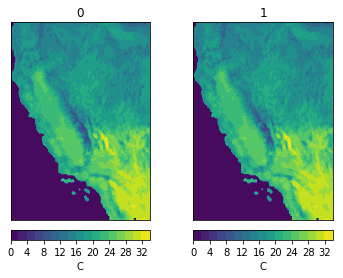

In [242]:
plt.figure(figsize=(5,10))

fig, ax = plt.subplots(1, 2)

ax[0].set_title('0')
map1 = setup_map(ax[0])

ax[1].set_title('1')
map2 = setup_map(ax[1])

plt.show()
